In [1]:
%load_ext cython

Essential syntax:

In [44]:
%%cython

# python-level import
import numpy as np

# bring C level symbols to the namespace
cimport numpy as cnp





# Example: apply a C function elementwise

In [3]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [45]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%%cython

cimport cython
import numpy as np


# Use the C standard library 
cdef extern from "math.h":
    double sin(double x) nogil


@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _compute_sine(double[:] a,           # typed memoryview syntax
                        double[::1] out) nogil:
    cdef Py_ssize_t j
    for j in range(a.shape[0]):
        out[j] = sin(a[j])


def sine(a):
    """Compute sin(a), elementwise."""
    a = np.asarray(a)
    
    # Store the shape and flatten the array
    a_shape = a.shape
    a = a.ravel()
    
    # allocate the output arrays in python (refcounting!)
    cdef double[::1] out = np.empty_like(a)
    
    # do the work
    _compute_sine(a, out)
    
    # wrap the result in a numpy array
    return np.asarray(out).reshape(a_shape)

In [5]:
import numpy as np

In [6]:
a = np.random.random(size=20).reshape(2, 5, 2)

In [7]:
res = sine(a)

In [8]:
res.shape

(2, 5, 2)

In [9]:
np.allclose(res, np.sin(a))

True

## Typed memoryview of a C array


In [10]:
%%cython

cimport cython
import numpy as np

cdef extern from "math.h":
    double sin(double x) nogil
    double M_PI


# Same _compute_sine as above

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _compute_sine(double[:] a,           # typed memoryview syntax
                        double[::1] out) nogil:
    cdef Py_ssize_t j
    for j in range(a.shape[0]):
        out[j] = sin(a[j])
        

def c_sine():
    """Create a C array, make a typed memoryview on it, and compute sines."""
    cdef double arr[8]
    
    for j in range(8):
        arr[j] = (j + 0.5) * M_PI
        
    cdef double[::1] view = arr
    cdef double[::1] out = np.empty(8, dtype=float)
    _compute_sine(view, out)
    
    ###### BIG FAT WARNING: `copy=True`, to avoid a dangling pointer. 
    return np.array(out, copy=True)

In [11]:
a = c_sine()
a

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [12]:
a.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

**Best allocate memory on the Python side.** Otherwise, tie the lifetime of pointers to some python objects. (E.g., declare a `cdef class Holder` to store the pointer, or --- better --- allocate and deallocate memory in constructor and destructor)

# Solve a Laplace equation, $\nabla^2 u = 0$

For simplicity, use some hard-coded boundary conditions.

Travis Oliphant, http://technicaldiscovery.blogspot.ru/2011/06/speeding-up-python-numpy-cython-and.html

In [13]:
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy

def py_update(u, dx2, xy2):
    nx, ny = u.shape
    for i in range(1,nx-1):
        for j in range(1, ny-1):
            u[i,j] = ((u[i+1, j] + u[i-1, j]) * dy2 +
                      (u[i, j+1] + u[i, j-1]) * dx2) / (2*(dx2+dy2))

            
def calc(N, n_iter=100, func=py_update):
    # set up the boundary condition
    u = np.zeros((N, N), dtype=float)
    u[0] = 1
    
    # loop
    for i in range(n_iter):
        func(u, dx2, dy2)
        
    return np.asarray(u)

In [14]:
u = calc(100, n_iter=2000)

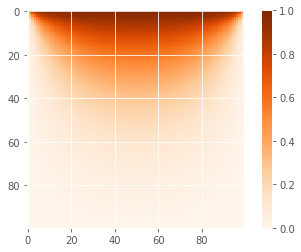

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.imshow(u, cmap=plt.cm.Oranges)
plt.colorbar()

In [16]:
%timeit calc(50, n_iter=1000)

5.11 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Move the update loop to Cython

In [17]:
%%cython -a --compile-args=-O3

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cy_update(double[:, ::1] u, double dx2, double dy2):
    cdef Py_ssize_t i, j
    for i in range(1, u.shape[0]-1):
        for j in range(1, u.shape[1]-1):
            u[i, j] = ((u[i+1, j] + u[i-1, j]) * dy2 +
                       (u[i, j+1] + u[i, j-1]) * dx2) / (2*(dx2+dy2))

In [18]:
u = calc(100, n_iter=8000, func=cy_update)

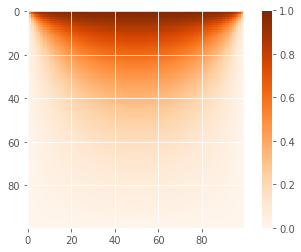

In [19]:
plt.imshow(u, cmap=plt.cm.Oranges)
plt.colorbar()

In [20]:
%timeit calc(50, n_iter=1000, func=cy_update)

18.7 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Practice exercises

1. Separate the boundary conditions from the `calc` function above. It should accept a preallocated array `u`.

2. Modify the ODE solver for `Planet` to output the trajectory as a numpy array.

3. Write a Cython function for a nearest-neighbor average of a 2D numpy array.

4. Find all solutions of the equation $x = a \, \sin{x}$. *Hint:* cythonize the bisection root-finding algorithm, and use it on each $2\pi$ interval.

In [29]:
%%cython -a

from libc.math cimport sqrt
cimport cython
import numpy as np

cdef class Planet(object):
    cdef public double x, y, z, vx, vy, vz, m
    def __init__(self):
        self.x = 1.0
        self.y = 0
        self.z = 0
        self.vx = 0
        self.vy = 0
        self.vz = 1.0
        
        self.m = 1.0


@cython.cdivision(True)
cdef void single_step(Planet planet,
                      double dt) nogil:
    """Make a single step in time, t -> t+dt."""
    # Gravitational force pulls towards origin
    cdef double r, r3
    r = sqrt(planet.x**2 + planet.y**2 + planet.z**2)
    r3 = r*r*r                             # XXX: check generated C code
    
    Fx = -planet.x / r3
    Fy = -planet.y / r3
    Fz = -planet.z / r3
    
    # update position
    planet.x += planet.vx * dt
    planet.y += planet.vy * dt
    planet.z += planet.vz * dt
    
    # update velocity
    m = planet.m
    planet.vx += Fx * dt / m
    planet.vy += Fy * dt / m
    planet.vz += Fz * dt / m


@cython.cdivision(True)
def propagate(planet,
              double time_span,
              int num_steps):
    """Make a number of time steps."""

    cdef double dt = time_span / num_steps
    cdef int j
    
    for j in range(num_steps):
        single_step(planet, dt)
    return np.array([[planet.x, planet.y, planet.z], [planet.vx, planet.vy, planet.vz]])

In [40]:
planet = Planet()
trajectory = propagate(planet, 1, 100)
print('position: ', trajectory[0], '\nvelocity: ', trajectory[1])

position:  [0.5452635 0.        0.8469516] 
velocity:  [-0.83939151  0.          0.54842162]


## 4. Find all solutions of the equation $x = a \, \sin{x}$. *Hint:* cythonize the bisection root-finding algorithm, and use it on each $2\pi$ interval.

Псевдокод

Пусть

    xn — начало отрезка по х;
    xk — конец отрезка по х;
    xi — середина отрезка по х;
    epsy — требуемая точность вычислений по y (заданное приближение интервала [xn; xk] : xk — xn к нулю).

Тогда алгоритм метода бисекции можно записать в псевдокоде следующим образом:

    Начало.
        Ввод xn, xk, epsy.
        Если F(xn) = 0, то Вывод (корень уравнения — xn).
        Если F(xk) = 0, то Вывод (корень уравнения — xk).
        Пока xk — xn > epsy повторять:
            dx := (xk — xn)/2
            xi := xn + dx;
            если sign(F(xn)) ≠ sign(F(xi)), то xk := xi;
            иначе xn := xi.
        конец повторять
        Вывод (Найден корень уравнения — xi с точностью по y — epsy).
    Конец.

In [51]:
%%cython -a

cimport cython
from libc.math cimport sin

cdef double f(double C, double x):
    return C * sin(x) - x

@cython.cdivision(True)

def bisect(double C, 
           double a, double b, 
           double eps):
    cdef double xn = a
    cdef double xk = b
    cdef double xi, funca, funcx
    cdef int k = 0
    while True:
        k += 1 
        xi = (xn + xk) / 2
        funca = f(C, xn)
        funcx = f(C, xi)
        if funca * funcx < 0:
            xk = xi
        else:
            xn = xi
        if (xk - xn) < 2 * eps:
            break
    return xi

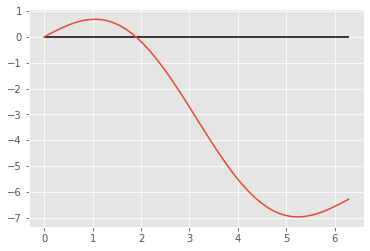

x =  1.8953249787934738


In [52]:
a = 0
b = 2 * np.pi
C = 2
xx = np.linspace(a, b)
plt.plot(xx, C * np.sin(xx) - xx)
plt.hlines(0, a, b)
plt.show()
print('x = ', bisect(C, a + 0.01, b, 0.001))
